# Poincaré Embeddings for Learning Hierarchical Representations
## By Vincent Benenati


## I. Introduction



Many machine learning algorithms first transform the feature space (*the sampled data of our dataset*) into a **"latent space"**  to **encode** pertitent information whilist often **reducing the dimensionality**, therefore reducing computational cost and memory usage, while **maintaining most of the important features** of the data.

Ideally, in this latent space more similar inputs should be "closer" together when using a particular distance metric. More dissimilar inputs should be "farther" apart using the same distance metric. 



<!-- ![title](assets/word2vecEmbedding.png) -->

<img src="assets/word2vecEmbedding.png" alt="drawing" width="1000"/>

The above figure depicts a particular embedding for English words. This particular implementation is known as **"word2vec"** and was ground-breaking at the time for being efficient to train and for encoding word similarity into a vectorspace. Two new prposed architectures generated the vector by either trying to predict the current word based on context (Bag-of-Words) or by predicting the surrounding words given the current word (Skip-gram). The vectors generated from these architectures allowed simple vector operations to be performed on words. Such as finding the vector from the embedding of "man" to "woman" and then applying this result to the embedding for "king". The result should be close to the embedding for "queen".


<!-- ![title](assets/glove.jpg) -->

<img src="assets/glove.jpg" alt="drawing" width="1000"/>

While word2vec implicitly uses the co-occurance counts of words, another algorithm called **GloVe** uses a co-occurance matrix directly to create the word embeddings. This results in an embedding space with similar properities and similar performance. However, GloVe's method is more easily parallelizable which allows for larger corpora to be used which can increase its performance.  

<!-- ![title](assets/node2vec.png) -->
<img src="assets/node2vec.png" alt="drawing" width="1000"/>

Embeddings are not just limited to words. Other algorithms have been developed to embed other forms of data into a vector space. One such example is **node2vec**. This algorithm can reduce the dimensionality of a graph by embedding nodes into a continuous vectorspace using biased random walks around the particular node's neighborhood. The resulting embeddings "learn representations that organize nodes based on their network roles and/or communities they be-long to."



<!-- ![title](assets/deepWalk.png) -->

<img src="assets/deepWalk.png" alt="drawing" width="1000"/>

Another alternative to node2vec is **DEEPWALK**. It also embeds nodes in a graph in a linear continous latent space. Rather than a biased random walk, it just uses a pure random walk with no hyperparameters that can adjust the depth of the walk. After the walk, it uses the skip-gram model just like node2vec.   

<!-- ![title](assets/poincareEmbedding.png) -->

<img src="assets/poincareEmbedding.png" alt="drawing" width="1000"/>

This paper proposes a new method of embedding data such that both similarity and hierarchy can be preserverd while also reducing the dimensionality. This is accomplished by using a non-linear latent space, an n-dimensional Poincaré ball. In some cases, hierarchy can be just as important as semantic similarity. One such example is taxonomical classifications of animals. Many different orders of mammal should all have about the same distance to the mammal point. This same embedding procedure can also be applied to data that orinially was not known to have a hierarchical structure. Another use case of this algorithm could be to confirm that existing hierarchical structures are based on real varying features rather than historical or cultural reasons.         

## II. Background & Model

Poincare Ball hyperbalic space, $\mathcal{B}^d$, is well suited for representing hierarchical data due to distances increasing exponentially the closer to the boundary a point is. This is not true for Euclidean space since these metrics only grow polynomially. Trees, a common data structure to represent hierarchical data, have a number of nodes that exponentially grows for each level the tree is traversed from the root. If this data was embedded in a Euclidean space, the number of dimensions would have to be very high in order to provide enough "room" for each node to be placed so that they are close to their similar counterparts but not too close to the dissimilar nodes. By using a Poincare Ball space instead, the number of required dimensions is drastically reduced for similar or sometimes better results.

The proposed model was intended to improve existing methods in two ways:
1. Creating a biased structure on the embedding space in order to learn more robust generalizations and decreased runtime/memory requirements
2. Capturing hierarchy explicitly in the embedding space

In order to learn these embeddings from a dataset, self-supervised learning is employed. 



### Riemenian Metric Tensor:
Since the machine learning is done on a non-Euclidean space, a Riemannian metric tensor must be defined instead:
$$
\begin{equation}
\tag{1}
g_x = (\frac{2}{1-\|{x}\|^2}) g^E
\end{equation}
$$
Where $g_x$ is the Riemannian metric tensor for the Poincare ball, $x \in \mathcal{B}^d$, and $g^E$ corresponds to the Euclidean metric tensor.



### Poincare Ball Distance:
After the Riemannian metric has been defined, the distance between two points in hyperbolic space is defined as:

$$
\begin{equation}
\tag{2}
d(u,v) = arcosh(1+2\frac{\|u-v\|^2}{(1-\|u\|^2)(1-\|v\|^2)})
\end{equation}
$$

Where **arcosh(\*)** is the hyperbolic arccosine and **||\*||** is the Euclidean norm.

Equation (2) allowed the authors to learn embeddings that simultaneously captured the
hierarchy of objects (through their norm) as well a their similarity (through their distance).
<!-- \newcommand{\La}{\mathcal{L}}
\newcommand{\Lb}{\pazocal{L}} -->



### Optimization Problem:

If we are finding embeddings $\Theta=\{\theta_i\}^n_{i=1}$ where $\theta_i \in \mathcal{B}^d$, we can optimize the following statement:
\begin{equation}
\tag{3}
\displaystyle
\Theta' \leftarrow \arg_\Theta \min \mathcal{L}(\Theta) \ni \forall \theta_i \in \Theta : \|\theta_i\|<1
\end{equation}

Notice how each $\|\theta_i\| <1$ which keeps each embedding inside the unit Poincare ball.



### Riemenian Stochastic Gradient Descent (RSGD):
To estimate an optimal solution for $\Theta$, Riemenian Stochastic Gradient Descent (RSGD) can be used on a defined loss function. This is a generalization of the Euclidean Stochastic Gradient Descent (SGD) algorithm. A random sample from the training data is used to calculate the loss with the current weights during the *forward pass*. Next, the riemenian gradient of the loss function is calculated using the sampled data points. The weights are updated a small amount according to the negative gradient and the learning rate, $\eta$. Over many iterations and seeds the loss function is iteratively minimized and hopefully a near global minima is found.     

<img src="assets/sgd.jpg" alt="drawing" width="1000"/>

This process is sumarized in the following equation:
\begin{equation}
\tag{4}
\theta_{t+1} = \mathcal{R}_{\theta_t}(-\eta_t\nabla_R\mathcal{L}(\theta_t))
\end{equation}

Where $\nabla_R$ is the Riemenian gradient, $\eta$ is the learning rate, and $\mathcal{R_{\theta_t}}$ is the retraction onto $\mathcal{B}$ at $\theta$. 

### Manifold Constraining through Projected-gradient:
The authors use a Projected-gradient method to map invalid points back onto the manifold while training:

\begin{equation}
\tag{5}
\theta_{t+1} \leftarrow {proj}(\theta_t - \eta_t\frac{(1-\|\theta_t\|^2)^2}{4}\nabla_E)
\end{equation}

The projection equation used is:

\begin{equation}
\tag{6}
proj(\theta) = \left\{
      \begin{array}{ll}\theta/\|\theta\|-\epsilon & \|\theta\|\geq1\\
      \theta & \|\theta\|<1 \\
\end{array} 
\right.
\end{equation}

The Euclidean graident is defined as: 
\begin{equation}
\tag{7}
\nabla_E = \frac{\partial\mathcal{L}(\theta)}{\partial d(\theta,x)}\frac{\partial d(\theta,x)}{\partial\theta}
\end{equation}

For datasets that are Directed Acyclic Graphs (DAG's), a transitive closure of relations can be generated. This results in a list of $child\rightarrow parent$ relations. WORDNET provides datasets of noun hierarchies and the mammal subtree can be used as a test case. Some relations in the WORDNET mammal subtree are shown below:  

<img src="assets/wordnetExample.png" alt="drawing" width="500"/>

In order to learn relevent embeddings, the authors used a variant of the log softmax function:
 
\begin{equation}
\tag{8}
\displaystyle\mathcal{L}(\Theta) = \sum_{(u,v)\in\mathcal{D}}{\log\frac{e^{-d(u,v)}}{\sum_{v'\in\mathcal{N}(u)e^{-d(u,v')}}}}
\end{equation}

Where $\mathcal{D}$ is the set of observed hypernymy relations between noun pairs and $\mathcal{N(u)}$ is the set of negative examples for u. In order to create $\mathcal{N(u)}$, the authors randomly sampled 10 negative samples per positive example.

## III. Implementation


### Preprocessing Dataset

First, the WORDNET dataset must be filtered to only include nouns associated with the mammal subtree.

### Vocabulary:
#### hypernym = a word with general meaning that more specific words fall under (e.g. color is a hypernym of red) 
#### hyponym = a word with specific meaning that falls under a word with more general meaning (e.g. red is a hyponym of color)

The data relations are stored as pairs such that:

hyponym->hypernym

## My Own Implementation Attempt

Several attempts were made to implement the model from scratch.  PyTorch was used in order to leverage the autograd capability. In order to use geomstats alongside, the backend was set to "pytorch" and checked.

In [6]:
import torch
from torch.nn import Embedding
from tqdm.notebook import tqdm
from nltk.corpus import wordnet as wn
import matplotlib.pyplot as plt
%matplotlib inline
import random
import numpy as np
import os
from geomstats import backend as gs
from geomstats.geometry.poincare_ball import PoincareBall, PoincareBallMetric

#Test to make sure that pytorch is the backend
print(os.environ["GEOMSTATS_BACKEND"])
print(type(gs.array(0)))


#epsilon for numerical stability
EPS = 1e-5
#the number of dimensions for each word embedding
EMBEDDING_DIM = 2

target = wn.synset('mammal.n.01')
words = wn.words()

metric = PoincareBallMetric(EMBEDDING_DIM)
manifold = PoincareBall(EMBEDDING_DIM)


INFO: Using pytorch backend


pytorch
<class 'torch.Tensor'>


Here the dataset is parsed in order to interface with the pytorch model easily.

In [9]:
#parse dataset into a usable data structure 

nouns = set()
for word in words:
    nouns.update(wn.synsets(word, pos='n'))

print(len(nouns), 'nouns')

hypernyms = []
for noun in nouns:
    paths = noun.hypernym_paths()
    for path in paths:
        try:
            pos = path.index(target)
            for i in range(pos, len(path)-1):
                hypernyms.append((noun, path[i]))
        except Exception:
            continue
            
hypernyms = np.array(list(set(hypernyms)))
uniq_hypernyms = np.array(list(set([e for tup in hypernyms for e in tup])))

word2idx = {val: i for i, val in enumerate(uniq_hypernyms)}
random.shuffle(hypernyms)

print(len(hypernyms), 'hypernyms' )

82115 nouns
6542 hypernyms


Here are a few functions that could be implemented using geomstats. However the model quickly converged to NaN using geomstats functions. This may be due to the lack of $\epsilon$ to prevent divide by zero or similar exceptions. Another concern was that the pytorch autograd would not work when these functions were implemented using geomstats. For these reasons, they were rewritten using pytorch vector operations that can support autograd.

In [43]:

def proj(point):
    '''
    Projects points outside of the Poincare ball back into the ball
    '''
    return manifold.projection(point)

def getLoss(u, v, negative_samples):
    '''
    Calculate loss
    '''
    loss = torch.sum(torch.log(torch.exp(-getDistance(u, v)) / torch.sum(torch.exp(-getDistance(u, negative_samples)))))
    return loss
    
def getDistance(u, v):
    '''
    Calculates the Riemannian distance between two points
    '''
    dist = metric.dist(u,v)
    dist = torch.reshape(dist, [1,-1])
    return dist


Here the functions required for learning on the poincare ball are implemented using pytorch vector operations.

In [7]:
def proj(theta):
    print("Theta: "+ str(theta))
    norm = torch.norm(theta, dim=1)
    theta = torch.where(norm>=1, torch.sub(torch.div(theta, norm),EPS), theta)
    return theta
    

def arcosh(x):
    theta = torch.log(torch.add(x,torch.sqrt(torch.sub(torch.pow(x,2),1))))
    return theta


def euclidean2RiemannianGradScale(theta):
    theta_sqnorm=torch.pow(torch.norm(theta),2)
    alpha = torch.sub(1,theta_sqnorm)
    alpha_sq = torch.pow(alpha,2)
    ratio = torch.div(alpha_sq, 4) 
    return ratio

def updateEmbedding(theta, learningRate):
    rGrad = torch.mul(euclidean2RiemannianGradScale(theta), theta.grad.data)
    step = torch.mul(learningRate, rGrad)
    theta = proj(torch.sub(theta, step))
    # theta.grad = None
    return theta


def getDistance(u, v):
    print("In getDistance: "+str(u)+"\n"+str(v))
    u_sq_norm = torch.pow(torch.norm(u, dim = 1),2)
    v_sq_norm = torch.pow(torch.norm(v, dim = 1),2)
    uv_norm = torch.norm(torch.sub(u,v), dim=1)
    uv_sq_norm = torch.pow(uv_norm,2)
    alpha = torch.sub(1,u_sq_norm)
    beta = torch.sub(1,v_sq_norm)
    numerator = torch.mul(2,uv_sq_norm)
    denominator = torch.mul(alpha,beta)
    ratio = torch.div(numerator, denominator)
    gamma = torch.add(1, ratio)
    return arcosh(gamma)

def getLoss(u, v, negative_samples):
    loss = torch.sum(torch.log(torch.exp(-getDistance(u, v)) / torch.sum(torch.exp(-getDistance(u, negative_samples)))))
    return loss

def plot():
    lhds, rhds = hypernyms[:, 0], hypernyms[:, 1]

    targets = set(lhd for i, lhd in enumerate(lhds) if rhds[i] == target)
    embeddings_np = embeddings.numpy()

    if len(targets) + 1 > 30:
        targets = random.sample(targets, 30-1)
    targets.append(target)
    
    fig = plt.figure(figsize=(10,10))
    ax = plt.gca()
    ax.cla() 

    ax.set_xlim((-1.1, 1.1))
    ax.set_ylim((-1.1, 1.1))

    circle = plt.Circle((0,0), 1., fill=False)
    ax.add_artist(circle)

    for n in targets:
        x, y = embeddings_np[word2idx[n]]
        ax.plot(x, y, 'o', color='y')
        ax.text(x+0.01, y+0.01, n.name())
    plt.show()

Here the model hyperparameters are set and the model is initialized with weights in a uniform distribution from -0.001 to 0.001 like the original paper. The learning rate and the burn in rate are 0.1 and 0.01 respectively just like the paper. The burn in is also the same as the paper at 10 epochs. However since so much time was wasted trying to get the geomstats implementation to work, the following model was never fully debugged. Since this is the first time I implemented a custom loss function, I am unfamilar with pytorch's autograd. The structure of the following model has errors in tracking the gradient. To compensate for this, analysis was performed on a gensim poincare model.

In [19]:
NUM_EPOCHS = 40
BURNIN_EPOCHS = 10

NORMAL_LR = 0.1
BURNIN_LR = NORMAL_LR/10
NUM_NEGATIVE_SAMPLES = 10

embeddings = torch.DoubleTensor(len(uniq_hypernyms), EMBEDDING_DIM)
torch.nn.init.uniform(embeddings,a=-0.001,b=0.001)
# embeddings = Embedding(len(uniq_hypernyms), EMBEDDING_DIM, sparse=False, max_norm=1.0)
# embeddings.weight.data.uniform_(-0.001,0.001)

#generate a tensor of negative samples for each epoch
negativeSamples = torch.from_numpy(np.random.randint(0, len(uniq_hypernyms), size=(NUM_EPOCHS, len(hypernyms), NUM_NEGATIVE_SAMPLES)))

progressbar_init = tqdm(range(NUM_EPOCHS))
for epoch in progressbar_init:
    if epoch<BURNIN_EPOCHS:
        LR = BURNIN_LR
    else:
        LR = NORMAL_LR
    
    progressbar_batch = tqdm(hypernyms, leave=False)
    for idx, (word1, word2) in enumerate(progressbar_batch):
        idx_word1 = torch.LongTensor([word2idx[word1]])
        idx_word2 = torch.LongTensor([word2idx[word2]])
        print("idx_word1: "+str(idx_word1))
        u = embeddings[idx_word1]
        v = embeddings[idx_word2]

        print("U: "+str(u))
        print("V: "+str(v))
        negative_samples = embeddings[negativeSamples[epoch, i]]
        print("Negative Samples: \n"+ str(negative_samples))
        
        #calculate loss from negative examples and u->v
        loss = getLoss(u,v,negative_samples)
       
        #calculate Euclidean gradient automatically
        loss.backward()
        print("Loss Type: "+str(type(loss)))
        print("Loss Shape: "+str(loss.shape))
        print("Loss grad: "+str(loss.grad))

        #update progress bar
        progressbar_batch.set_postfix(loss=loss)
        
        #update embeddings
        updateEmbedding(negative_samples, LR)
        updateEmbedding(u,LR)
        updateEmbedding(v,LR)
        

/tmp/ipykernel_15759/3261543874.py:9: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  torch.nn.init.uniform(embeddings,a=-0.001,b=0.001)


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6542 [00:00<?, ?it/s]

idx_word1: tensor([130])
U: tensor([[-0.0002,  0.0006]], dtype=torch.float64)
V: tensor([[-0.0003,  0.0008]], dtype=torch.float64)
Negative Samples: 
tensor([[ 0.0002, -0.0001],
        [ 0.0007, -0.0005],
        [ 0.0005, -0.0006],
        [-0.0006,  0.0006],
        [-0.0004, -0.0009],
        [-0.0006, -0.0008],
        [-0.0002,  0.0006],
        [ 0.0002, -0.0008],
        [ 0.0006, -0.0008],
        [-0.0006,  0.0003]], dtype=torch.float64)
In getDistance: tensor([[-0.0002,  0.0006]], dtype=torch.float64)
tensor([[-0.0003,  0.0008]], dtype=torch.float64)
In getDistance: tensor([[-0.0002,  0.0006]], dtype=torch.float64)
tensor([[ 0.0002, -0.0001],
        [ 0.0007, -0.0005],
        [ 0.0005, -0.0006],
        [-0.0006,  0.0006],
        [-0.0004, -0.0009],
        [-0.0006, -0.0008],
        [-0.0002,  0.0006],
        [ 0.0002, -0.0008],
        [ 0.0006, -0.0008],
        [-0.0006,  0.0003]], dtype=torch.float64)


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

## Visualizing with Gensim

First the WORDNET dataset is downloaded from the NLTK library.

In [9]:
import re
import pandas
from nltk.corpus import wordnet as wn
from tqdm import tqdm

#Download the WORDNET dataset
try:
    wn.all_synsets
except LookupError as e:
    import nltk
    nltk.download('wordnet')


Here the dataset is navigated and each synonym network (synset) is navigated. Finally the data is set into a pandas dataframe.

In [3]:
%%capture
#%%capture is used to hush the printout

# make sure each edge is included only once
edges = set()

#iterate through every "synonym network" that are nouns
for synset in tqdm(wn.all_synsets(pos='n')):
    # write the transitive closure of all hypernyms of a synset to file
    for hyper in synset.closure(lambda s: s.hypernyms()):
        edges.add((synset.name(), hyper.name()))

    # also write transitive closure for all instances of a synset
    for instance in synset.instance_hyponyms():
        for hyper in instance.closure(lambda s: s.instance_hypernyms()):
            edges.add((instance.name(), hyper.name()))
            for h in hyper.closure(lambda s: s.hypernyms()):
                edges.add((instance.name(), h.name()))

#insert the set into a pandas datafram
nouns = pandas.DataFrame(list(edges), columns=['id1', 'id2'])
nouns['weight'] = 1


NameError: name 'tqdm' is not defined

The following code snippet manipulates the dataset so it is ready to be loaded into the model.

In [11]:
# Extract the set of nouns that have "mammal.n.01" as a hypernym
mammal_set = set(nouns[nouns.id2 == 'mammal.n.01'].id1.unique())
mammal_set.add('mammal.n.01')

# Select relations that have a mammal as hypo and hypernym
mammals = nouns[nouns.id1.isin(mammal_set) & nouns.id2.isin(mammal_set)]

#create a regular expression filter
with open('./wordnet/mammals_filter.txt', 'r') as fin:
    filt = re.compile(f'({"|".join([l.strip() for l in fin.readlines()])})')

#apply the regular expression filter
filtered_mammals = mammals[~mammals.id1.str.cat(' ' + mammals.id2).str.match(filt)]

#save the closures to files
nouns.to_csv('noun_closure.csv', index=False)
filtered_mammals.to_csv('mammal_closure.csv', index=False)

The following code sets the models to learn embeddings for the mammal relations and imports the necessary packages. In order to display the plots in GitHub, the plotly renderer was set to png. In order to see interactive figures with node labels, open the figures in the iframe_figures page with a web browser or download the notebook, comment out the "pio.renderers.default = 'png'" line and rerun the plotting code snippets below.

In [1]:
from gensim.models.poincare import PoincareModel, PoincareRelations
from gensim.test.utils import datapath
from gensim.models import KeyedVectors
from gensim.viz.poincare import poincare_2d_visualization
import plotly.io as pio

pio.renderers.default = 'png'

import os
from plotly.offline import init_notebook_mode, iplot
import numpy as np

MAMMAL_FILE_PATH = datapath(os.getcwd()+'/wordnet/mammal_closure_noweights.csv')
NOUN_FILE_PATH = datapath(os.getcwd()+'/wordnet/noun_closure_noweights.csv')

mammal_relations = PoincareRelations(MAMMAL_FILE_PATH, delimiter=',')


In order to analyze the effects of the several hyperparameters, 81 different models were trained to be analyzed.

In [2]:
%%capture
#Train and save several models with varying hyperparameters
for curr_alpha in np.linspace(0.1, 0.5, 3,dtype=float):
    for curr_burn_in in np.linspace(0,50,3,dtype=int):
        for curr_negatives in np.linspace(2,10,3,dtype=int):
            for curr_num_epochs in np.linspace(50, 500, 3,dtype=int):
                model_name = "poincare_alpha{}_burn{}_neg{}_epoch{}.model".format(curr_alpha, curr_burn_in, curr_negatives, curr_num_epochs)
                print("Starting "+ model_name +"\n")
                model = PoincareModel(mammal_relations, alpha = curr_alpha, burn_in_alpha=curr_alpha/10, size = 2, workers = 1, burn_in = curr_burn_in, negative=curr_negatives)
                model.train(epochs=round(curr_num_epochs), print_every=10)
                model.save(os.getcwd()+"/models/mammal/"+model_name)


NameError: name 'np' is not defined

## IV. Demonstration & Analysis

### Compare Burn-In

The authors use burn in to bias embeddings to adjust their angles rather than to move closer to the boundary of the poincare disk. This in turn creates better embeddings with better hierarchical information. It seems desirable to set burn in to 50 epochs.  

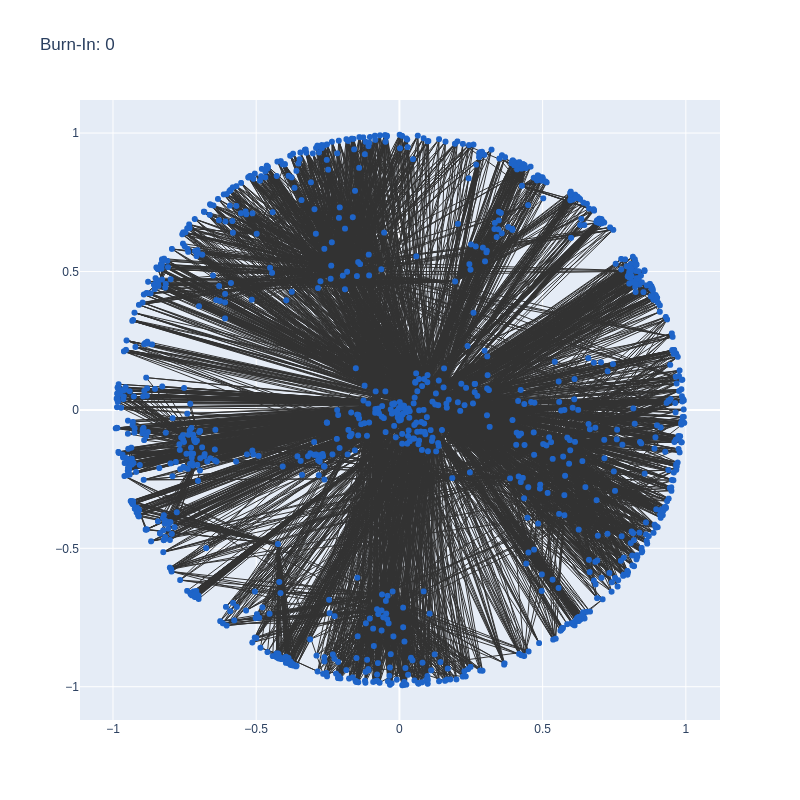

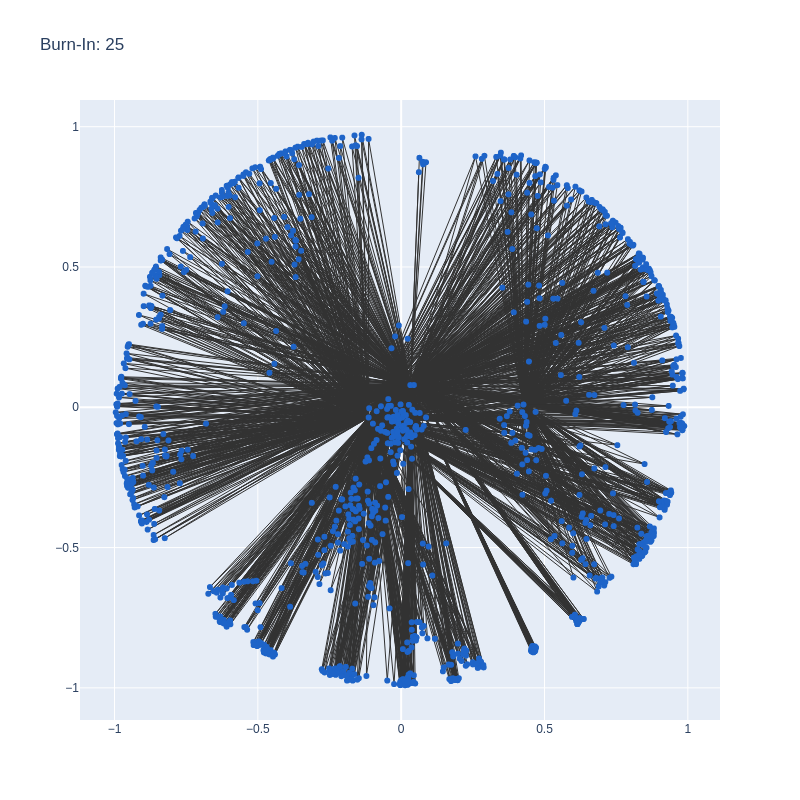

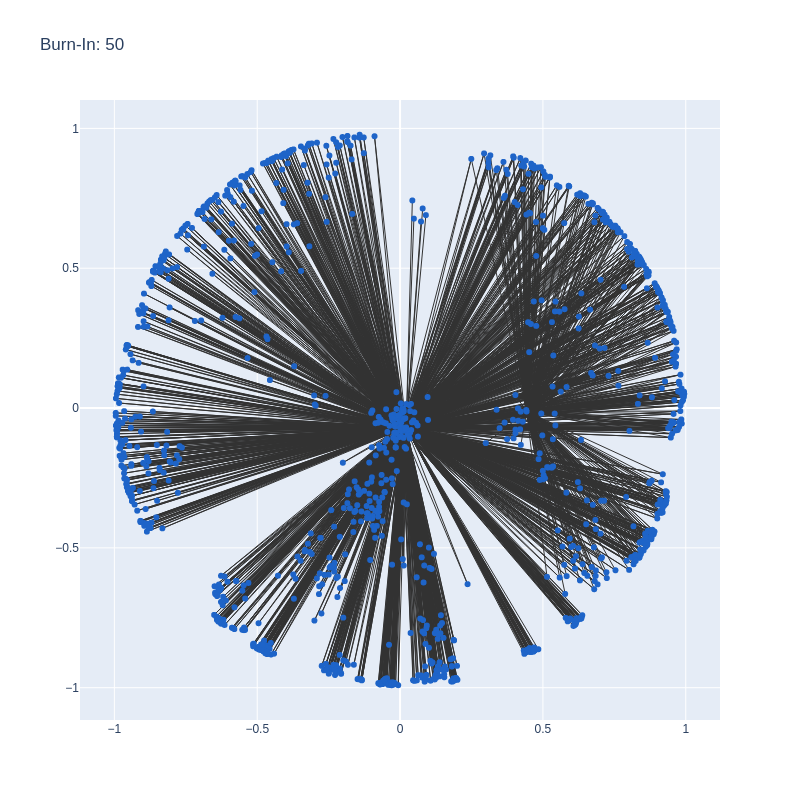

In [2]:
MODEL_NAME = "poincare_alpha0.1_burn0_neg6_epoch50.model"
model = PoincareModel.load(os.getcwd()+"/models/mammal/"+MODEL_NAME)
fig = poincare_2d_visualization(model, PoincareRelations(MAMMAL_FILE_PATH, delimiter=','), "Burn-In: 0", num_nodes=50, show_node_labels=())
pio.show(fig)

MODEL_NAME = "poincare_alpha0.1_burn25_neg6_epoch50.model"
model = PoincareModel.load(os.getcwd()+"/models/mammal/"+MODEL_NAME)
fig = poincare_2d_visualization(model, PoincareRelations(MAMMAL_FILE_PATH, delimiter=','), "Burn-In: 25", num_nodes=3)
pio.show(fig)

MODEL_NAME = "poincare_alpha0.1_burn50_neg6_epoch50.model"
model = PoincareModel.load(os.getcwd()+"/models/mammal/"+MODEL_NAME)
fig = poincare_2d_visualization(model, PoincareRelations(MAMMAL_FILE_PATH, delimiter=','), "Burn-In: 50", num_nodes=3)
pio.show(fig)


### Compare Number of Epochs 

The number of epochs adjusts how long the model is trained. Too many epochs and the model may overfit the data which means it does not generalize well and has a poor job of extrapolating outside data. Too few epochs and the model does not learn enough valuable features from the dataset. While 50 epochs is too few, it seems that 275 and 500 are good to learn embeddings. This may be adjusted to compensate for learning rate.

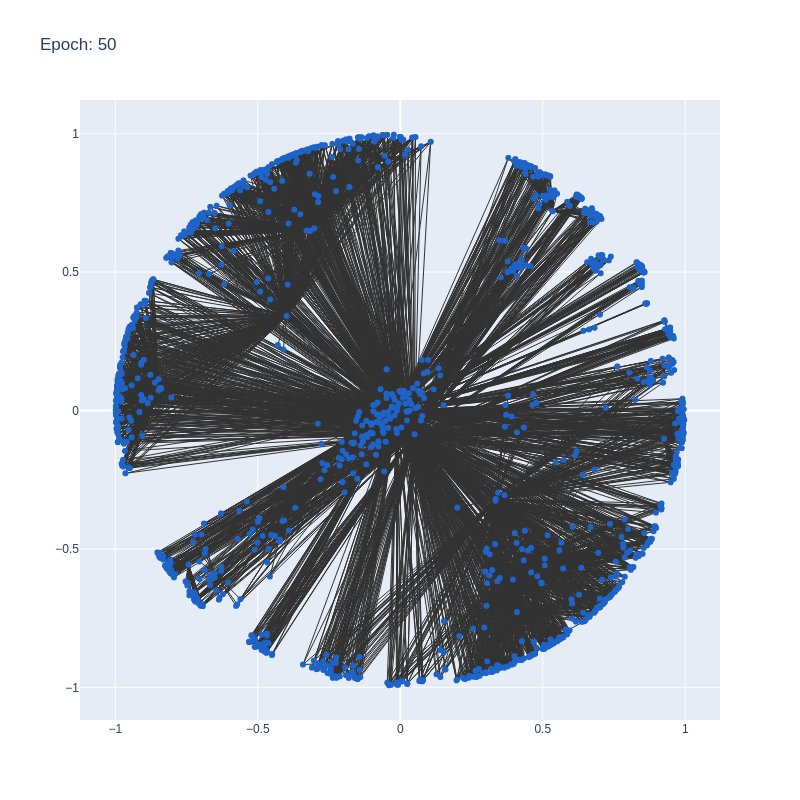

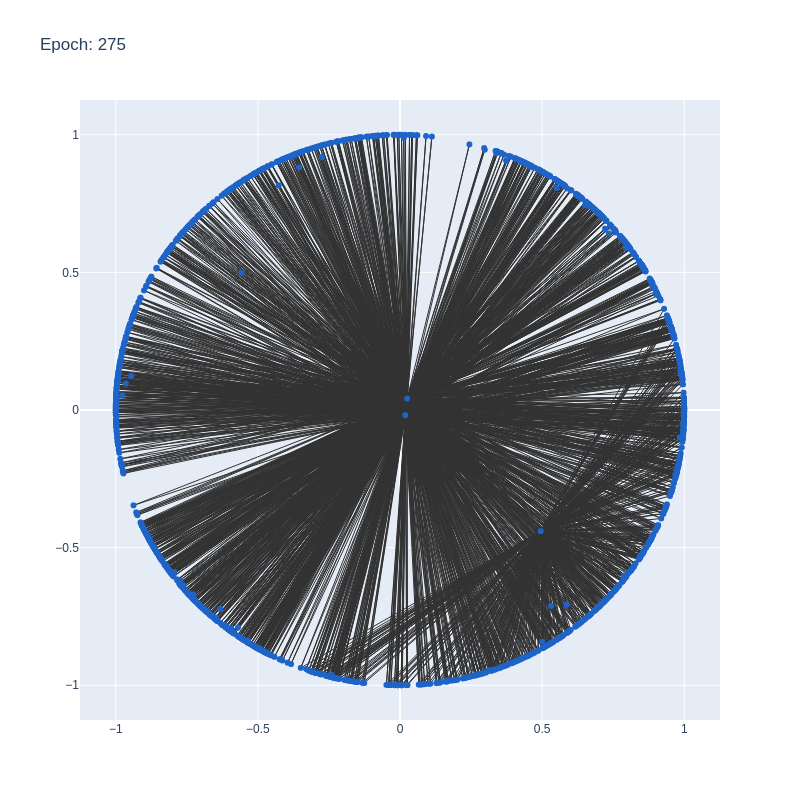

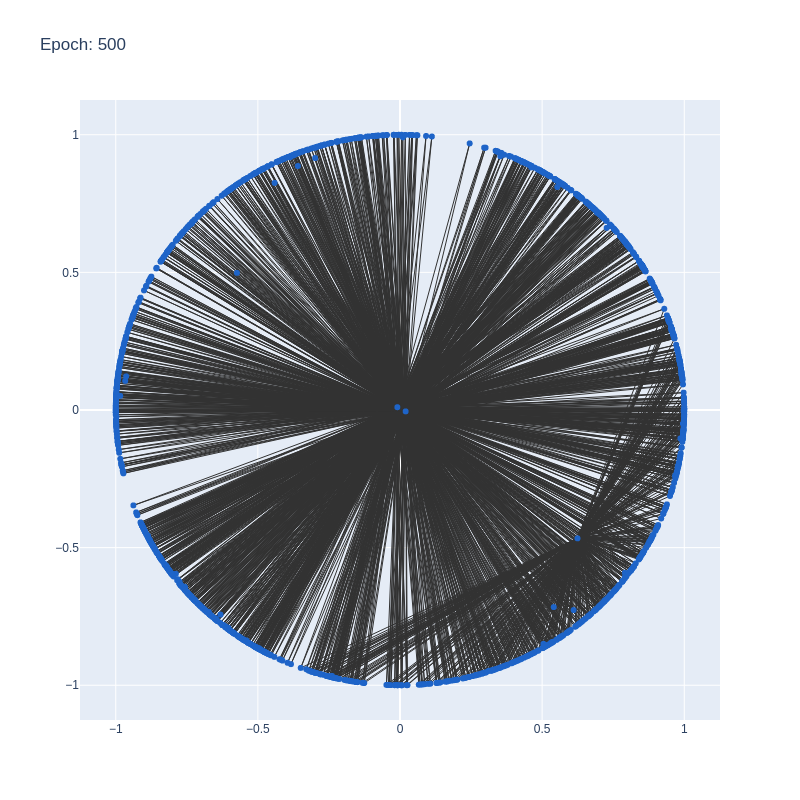

In [3]:
MODEL_NAME = "poincare_alpha0.1_burn50_neg10_epoch50.model"
model = PoincareModel.load(os.getcwd()+"/models/mammal/"+MODEL_NAME)
fig = poincare_2d_visualization(model, PoincareRelations(MAMMAL_FILE_PATH, delimiter=','), "Epoch: 50", num_nodes=50, show_node_labels=())
pio.show(fig)

MODEL_NAME = "poincare_alpha0.1_burn50_neg10_epoch275.model"
model = PoincareModel.load(os.getcwd()+"/models/mammal/"+MODEL_NAME)
fig = poincare_2d_visualization(model, PoincareRelations(MAMMAL_FILE_PATH, delimiter=','), "Epoch: 275", num_nodes=3)
pio.show(fig)

MODEL_NAME = "poincare_alpha0.1_burn50_neg10_epoch500.model"
model = PoincareModel.load(os.getcwd()+"/models/mammal/"+MODEL_NAME)
fig = poincare_2d_visualization(model, PoincareRelations(MAMMAL_FILE_PATH, delimiter=','), "Epoch: 500", num_nodes=3)
pio.show(fig)



### Compare Learning-Rate 

The learning rate, $\eta$, adjusts how large the gradient descent step is. Too large of a step, the system may never converge to a good solution. Too small of a rate, the system will take too long to learn good embeddings and may never adjust the weights due to the stochastic nature. The models with learning rates of 0.3 and 0.5 did not learn as much hierarchical structure and seems that the nodes converged to the boundary of the poincare disk. It seems that a learning rate of 0.1 is desirable.

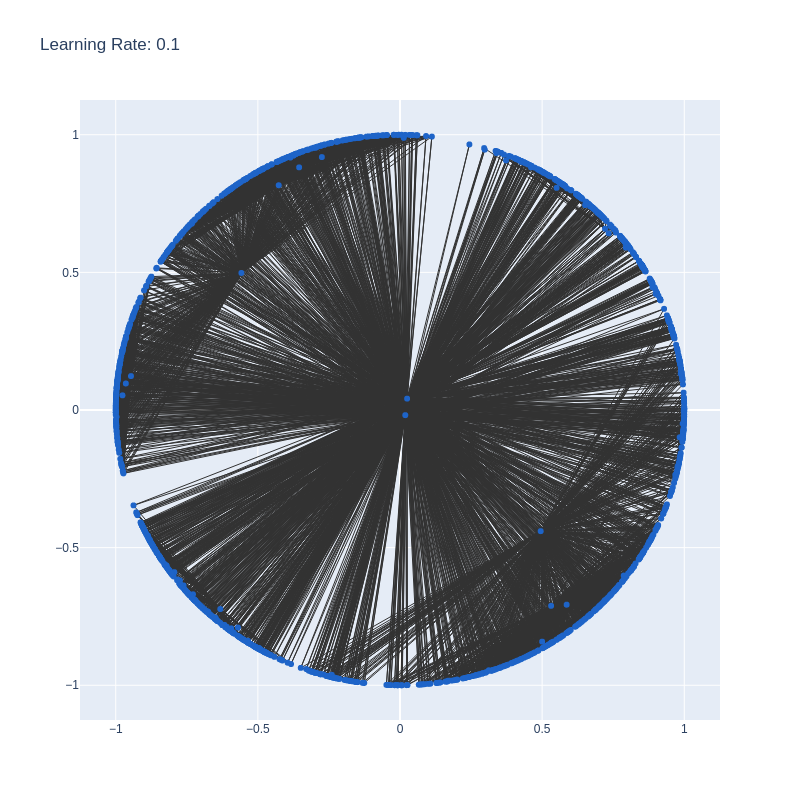

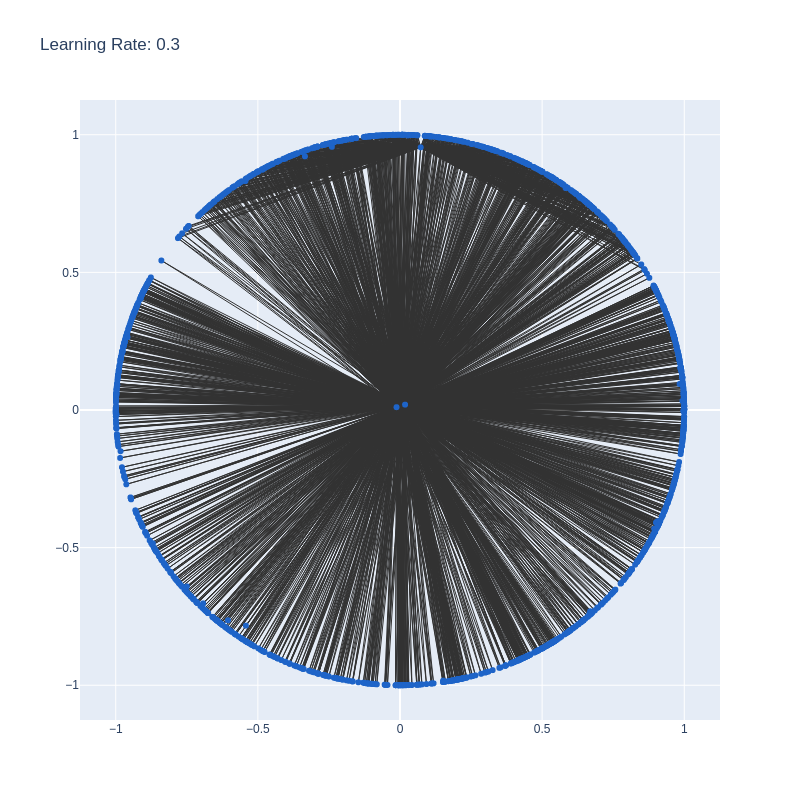

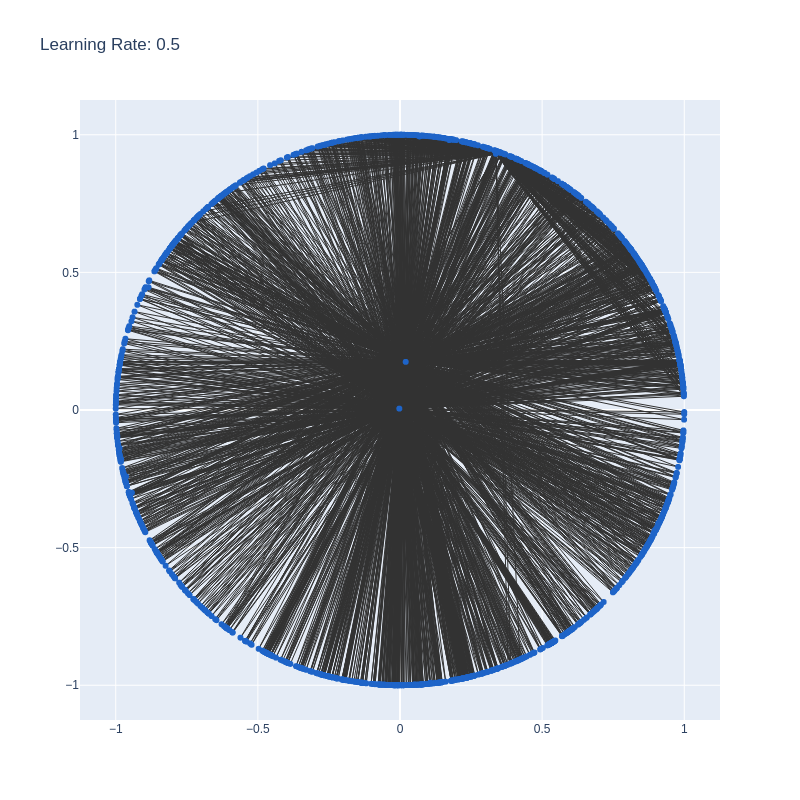

In [4]:
MODEL_NAME = "poincare_alpha0.1_burn50_neg10_epoch275.model"
model = PoincareModel.load(os.getcwd()+"/models/mammal/"+MODEL_NAME)
fig = poincare_2d_visualization(model, PoincareRelations(MAMMAL_FILE_PATH, delimiter=','), "Learning Rate: 0.1", num_nodes=50, show_node_labels=())
pio.show(fig)

MODEL_NAME = "poincare_alpha0.30000000000000004_burn50_neg10_epoch275.model"
model = PoincareModel.load(os.getcwd()+"/models/mammal/"+MODEL_NAME)
fig = poincare_2d_visualization(model, PoincareRelations(MAMMAL_FILE_PATH, delimiter=','), "Learning Rate: 0.3", num_nodes=3)
pio.show(fig)

MODEL_NAME = "poincare_alpha0.5_burn50_neg10_epoch275.model"
model = PoincareModel.load(os.getcwd()+"/models/mammal/"+MODEL_NAME)
fig = poincare_2d_visualization(model, PoincareRelations(MAMMAL_FILE_PATH, delimiter=','), "Learning Rate: 0.5", num_nodes=3)
pio.show(fig)



### Compare Number of Negative Examples

The number of negative examples modifies how many different nodes the current node of interest is compared to before the loss function is calculated. The higher the number, the longer it takes to calculate the loss function.

However, by comparing more negative examples, it seems that the embeddings represent hierarchical representations better. Using 10 samples seems desirable.

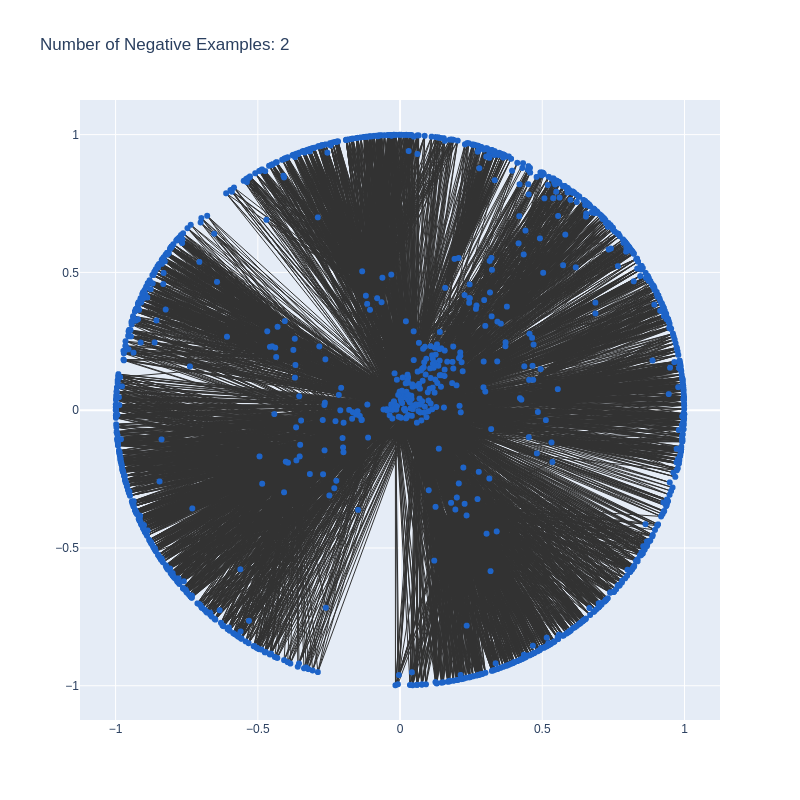

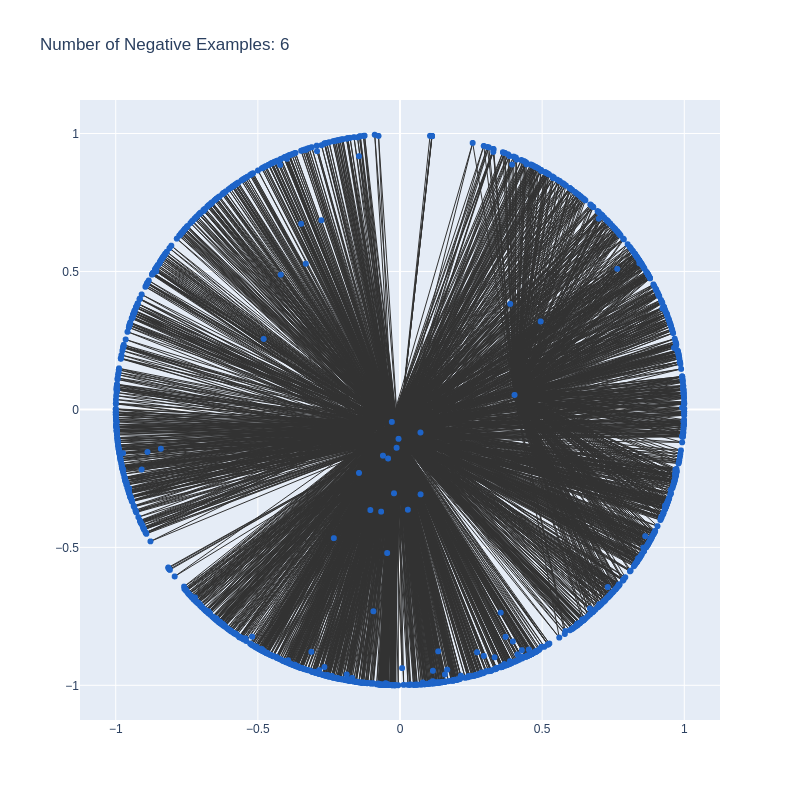

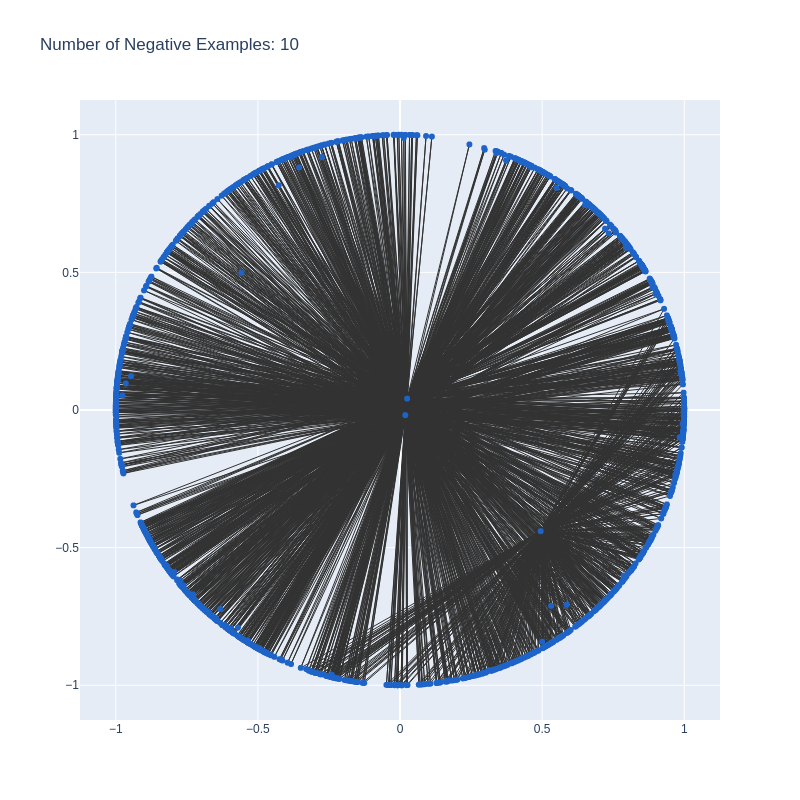

In [5]:
MODEL_NAME = "poincare_alpha0.1_burn50_neg2_epoch275.model"
model = PoincareModel.load(os.getcwd()+"/models/mammal/"+MODEL_NAME)
fig = poincare_2d_visualization(model, PoincareRelations(MAMMAL_FILE_PATH, delimiter=','), "Number of Negative Examples: 2", num_nodes=50, show_node_labels=())
pio.show(fig)

MODEL_NAME = "poincare_alpha0.1_burn50_neg6_epoch275.model"
model = PoincareModel.load(os.getcwd()+"/models/mammal/"+MODEL_NAME)
fig = poincare_2d_visualization(model, PoincareRelations(MAMMAL_FILE_PATH, delimiter=','), "Number of Negative Examples: 6", num_nodes=3)
pio.show(fig)

MODEL_NAME = "poincare_alpha0.1_burn50_neg10_epoch275.model"
model = PoincareModel.load(os.getcwd()+"/models/mammal/"+MODEL_NAME)
fig = poincare_2d_visualization(model, PoincareRelations(MAMMAL_FILE_PATH, delimiter=','), "Number of Negative Examples: 10", num_nodes=3)
pio.show(fig)



### Combining the Best Hyperparameters

If we assume that each hyperparameter independently modifies the model to some extent, we may be able to tune each hyperparameter independently. A rather good model can be found by using a learning rate of 0.1, a burn in of 50 epochs, a comparison of 10 negative samples, and a total of 500 training epochs.

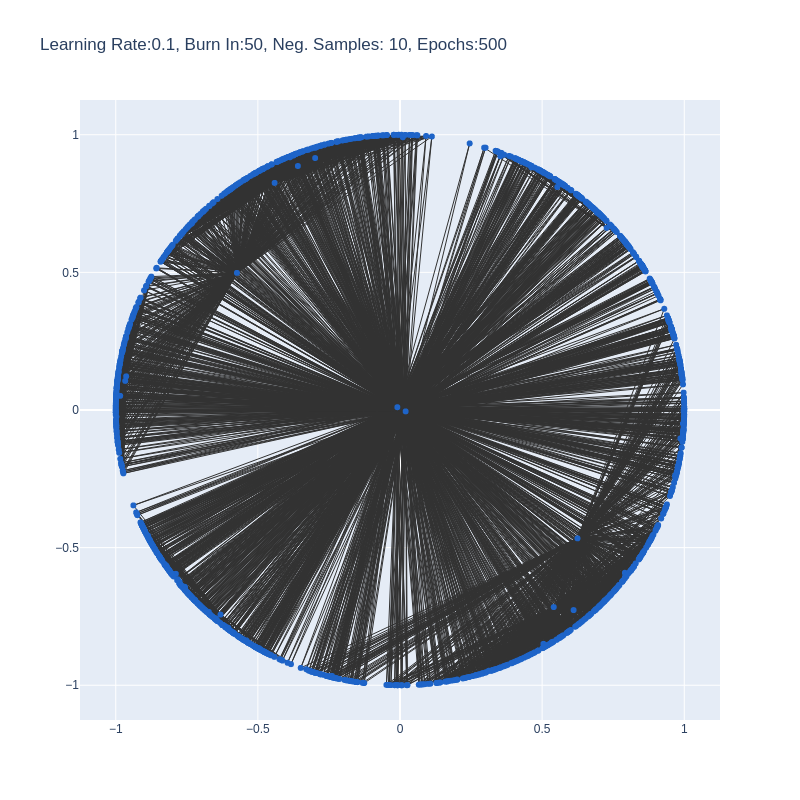

In [8]:
MODEL_NAME = "poincare_alpha0.1_burn50_neg10_epoch500.model"
model = PoincareModel.load(os.getcwd()+"/models/mammal/"+MODEL_NAME)
fig = poincare_2d_visualization(model, PoincareRelations(MAMMAL_FILE_PATH, delimiter=','), "Learning Rate:0.1, Burn In:50, Neg. Samples: 10, Epochs:500", num_nodes=50, show_node_labels=())
pio.show(fig)

## V. Citations


<!-- Nickel, Maximillian and Douwe Kiela (2017). “Poincaré Embeddings for Learning Hierarchical Representations”. In: Advances in Neural Information Processing Systems 30. Ed. by I Guyon, U V Luxburg, S Bengio, H Wallach, R Fergus, et al. Curran Associates, Inc. -->

Nickel, Maximillian and Douwe Kiela. Poincaré Embeddings for Learning Hierarchical Representations. Advances in Neural Information Processing Systems 30. Ed. by I Guyon, U V Luxburg, S Bengio, H Wallach, R Fergus, et al. Curran Associates, Inc.

<!-- Mikolov, Chen, Corrado and Dean (2013). "Efficient Estimation of Word Representations in Vector Space". In: arXiv:1301.3781 -->

Tomas Mikolov, Ilya Sutskever, Kai Chen, Greg Corrado, and Jeffrey Dean. Distributed
representations of words and phrases and their compositionality. CoRR, abs/1310.4546, 2013.

Jeffrey Pennington, Richard Socher, and Christopher D Manning. Glove: Global vectors for
word representation. In EMNLP, volume 14, pages 1532–1543, 2014.

Bryan Perozzi, Rami Al-Rfou, and Steven Skiena. Deepwalk: Online learning of social repre-
sentations. In Proceedings of the 20th ACM SIGKDD international conference on Knowledge
discovery and data mining, pages 701–710. ACM, 2014.

Aditya Grover and Jure Leskovec. node2vec: Scalable feature learning for networks. In
Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and
Data Mining, pages 855–864. ACM, 2016.